## Face and Facial Keypoint detection

After you've trained a neural network to detect facial keypoints, you can then apply this network to *any* image that includes faces. The neural network expects a Tensor of a certain size as input and, so, to detect any face, you'll first have to do some pre-processing.

1. Detect all the faces in an image using a face detector (we'll be using a Haar Cascade detector in this notebook).
2. Pre-process those face images so that they are grayscale, and transformed to a Tensor of the input size that your net expects. This step will be similar to the `data_transform` you created and applied in Notebook 2, whose job was tp rescale, normalize, and turn any iimage into a Tensor to be accepted as input to your CNN.
3. Use your trained model to detect facial keypoints on the image.

---

In [0]:
#Downloading Haar Cascade Model for face detection
!mkdir /detector_architectures
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml -O /detector_architectures/haarcascade_frontalface_default.xml

In [0]:
#import libraries

import numpy as np 
import pandas as pd 
import cv2
import matplotlib.pyplot as plt
import glob 
from PIL import Image
import matplotlib.image as mpimg
import os 
import torch
import random
from models import FaceNet

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed = 0
seed_everything(seed)

In [0]:
def preprocess(face_image):
  face_image = cv2.cvtColor(face_image,cv2.COLOR_RGB2GRAY)
  face_image = face_image/255.0
  face_image = cv2.resize(face_image,(224, 224))
  face_image = face_image.reshape((224,224,1))
  face_image = np.transpose(face_image,(2, 0, 1))
  face_image = torch.tensor(face_image)
  return face_image


def detect_faces(image):
  face_cascade = cv2.CascadeClassifier('/detector_architectures/haarcascade_frontalface_default.xml')
  faces = face_cascade.detectMultiScale(image,1.5,3)
  image_det = image.copy()
  for (x,y,w,h) in faces:
      x1 = max(x-10,0)
      y1 = max(y-10,0)
      x2 = min(image_det.shape[1],x+w+30)
      y2 = min(image_det.shape[0],y+h+30)
      cv2.rectangle(image_det,(x1,y1),(x2,y2),(255,0,0),5)
  fig = plt.figure(figsize=(9,9))
  plt.imshow(image_det)
  return faces

def detect_keypoints(image,faces):
  num_faces = len(faces)
  fig = plt.figure(figsize=(10,5))
  if num_faces % 2 == 0:
    rows,cols = int(num_faces/2),int(num_faces)
  else:
    rows,cols = int(num_faces/2) + 1,int(num_faces)
  

  images = torch.tensor(np.ones((len(faces),1,224,224))).double()
  
  for i,(x,y,w,h) in enumerate(faces):
    x1 = max(x-10,0)
    y1 = max(y-10,0)
    x2 = min(image.shape[1],x+w+30)
    y2 = min(image.shape[0],y+h+30)
    image_face = image[y1:y2,x1:x2]
    image_face = preprocess(image_face)
    images[i] = image_face
  with torch.no_grad():
      model.eval()
      model.double()
      pred_key_pts = model(images)
  pred_key_pts = pred_key_pts.reshape((-1,68,2))
  for idx in range(len(images)):
    image_idx = images[idx].numpy().squeeze(0)
    key_pts_idx = pred_key_pts[idx]
    key_pts_idx = key_pts_idx*50.0+100
    key_pts_idx = key_pts_idx.numpy()
    fig.add_subplot(rows,cols,idx+1)
    plt.imshow(image_idx,cmap='gray')
    plt.scatter(key_pts_idx[:,0],key_pts_idx[:,1],s=20,marker='.',c='m')
  return None


## Loading in a trained model

Once you have an image to work with (and, again, you can select any image of faces in the `images/` directory), the next step is to pre-process that image and feed it into your CNN facial keypoint detector.

First, load your best model by its filename.

In [0]:
model = FaceNet()
model.load_state_dict(torch.load('/models/model.pt'))
model.eval()

FaceNet(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (d1): Dropout(p=0.2, inplace=False)
  (conv6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (d2): Dropout(p=0.2, inplace=False)
  (conv8): Conv2d(64, 128, kernel

## Keypoint detection

Now, we'll loop over each detected face in an image (again!) only this time, you'll transform those faces in Tensors that your CNN can accept as input images.

### TODO: Transform each detected face into an input Tensor

You'll need to perform the following steps for each detected face:
1. Convert the face from RGB to grayscale
2. Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
3. Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
4. Reshape the numpy image into a torch image.

**Hint**: The sizes of faces detected by a Haar detector and the faces your network has been trained on are of different sizes. If you find that your model is generating keypoints that are too small for a given face, try adding some padding to the detected `roi` before giving it as input to your model.

You may find it useful to consult to transformation code in `data_load.py` to help you perform these processing steps.


### TODO: Detect and display the predicted keypoints

After each face has been appropriately converted into an input Tensor for your network to see as input, you can apply your `net` to each face. The ouput should be the predicted the facial keypoints. These keypoints will need to be "un-normalized" for display, and you may find it helpful to write a helper function like `show_keypoints`. You should end up with an image like the following with facial keypoints that closely match the facial features on each individual face:





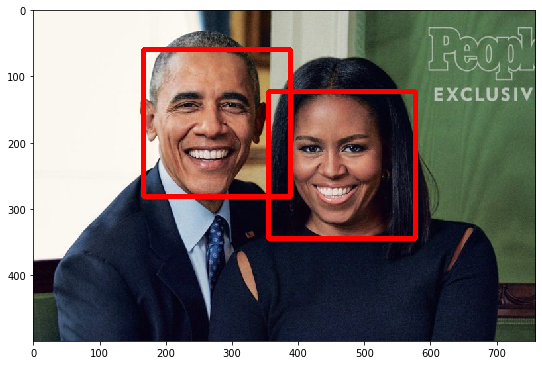

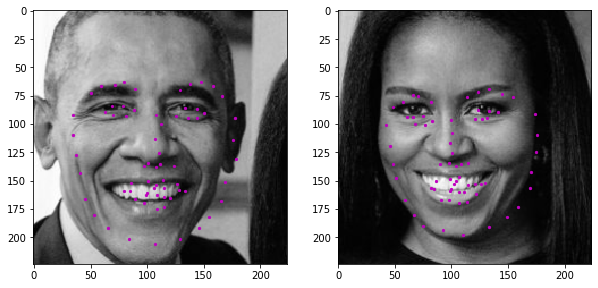

In [0]:
image = cv2.imread('/images/obamas.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
faces_image = detect_faces(image)
detect_keypoints(image,faces_image)